In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def extract_arch(model):
    try:
        vit, size, patch_size, *rest = model.split("-")
        return vit+"-"+size+"-"+patch_size
    except Exception:
        return model
plt.rcParams['figure.dpi'] = 200

In [5]:
dataset_type = pd.read_csv("dataset_type.csv").set_index("dataset")["type"].to_dict()
df = pd.read_csv("bench_official/benchmark.csv")
vtab_plus = list(map(lambda s:s.strip(), open("datasets.txt").readlines()))
df = df[df.dataset.isin(vtab_plus)]
df.loc[:, "dataset_type"] = df.dataset.apply(lambda d:dataset_type[d])
df.loc[:, "model_arch"] = df.model.apply(extract_arch)

In [6]:
df_retrieval = df[df["dataset_type"] == "retrieval"]
df = df[df["dataset_type"] != "retrieval"]
df = df.drop(["image_retrieval_recall@5", "text_retrieval_recall@5"], axis=1)
dataset_type = {k:v for k,v in dataset_type.items() if v != "retrieval"}

# Accuracy of all models on all datasets

<Axes: xlabel='dataset', ylabel='acc1'>

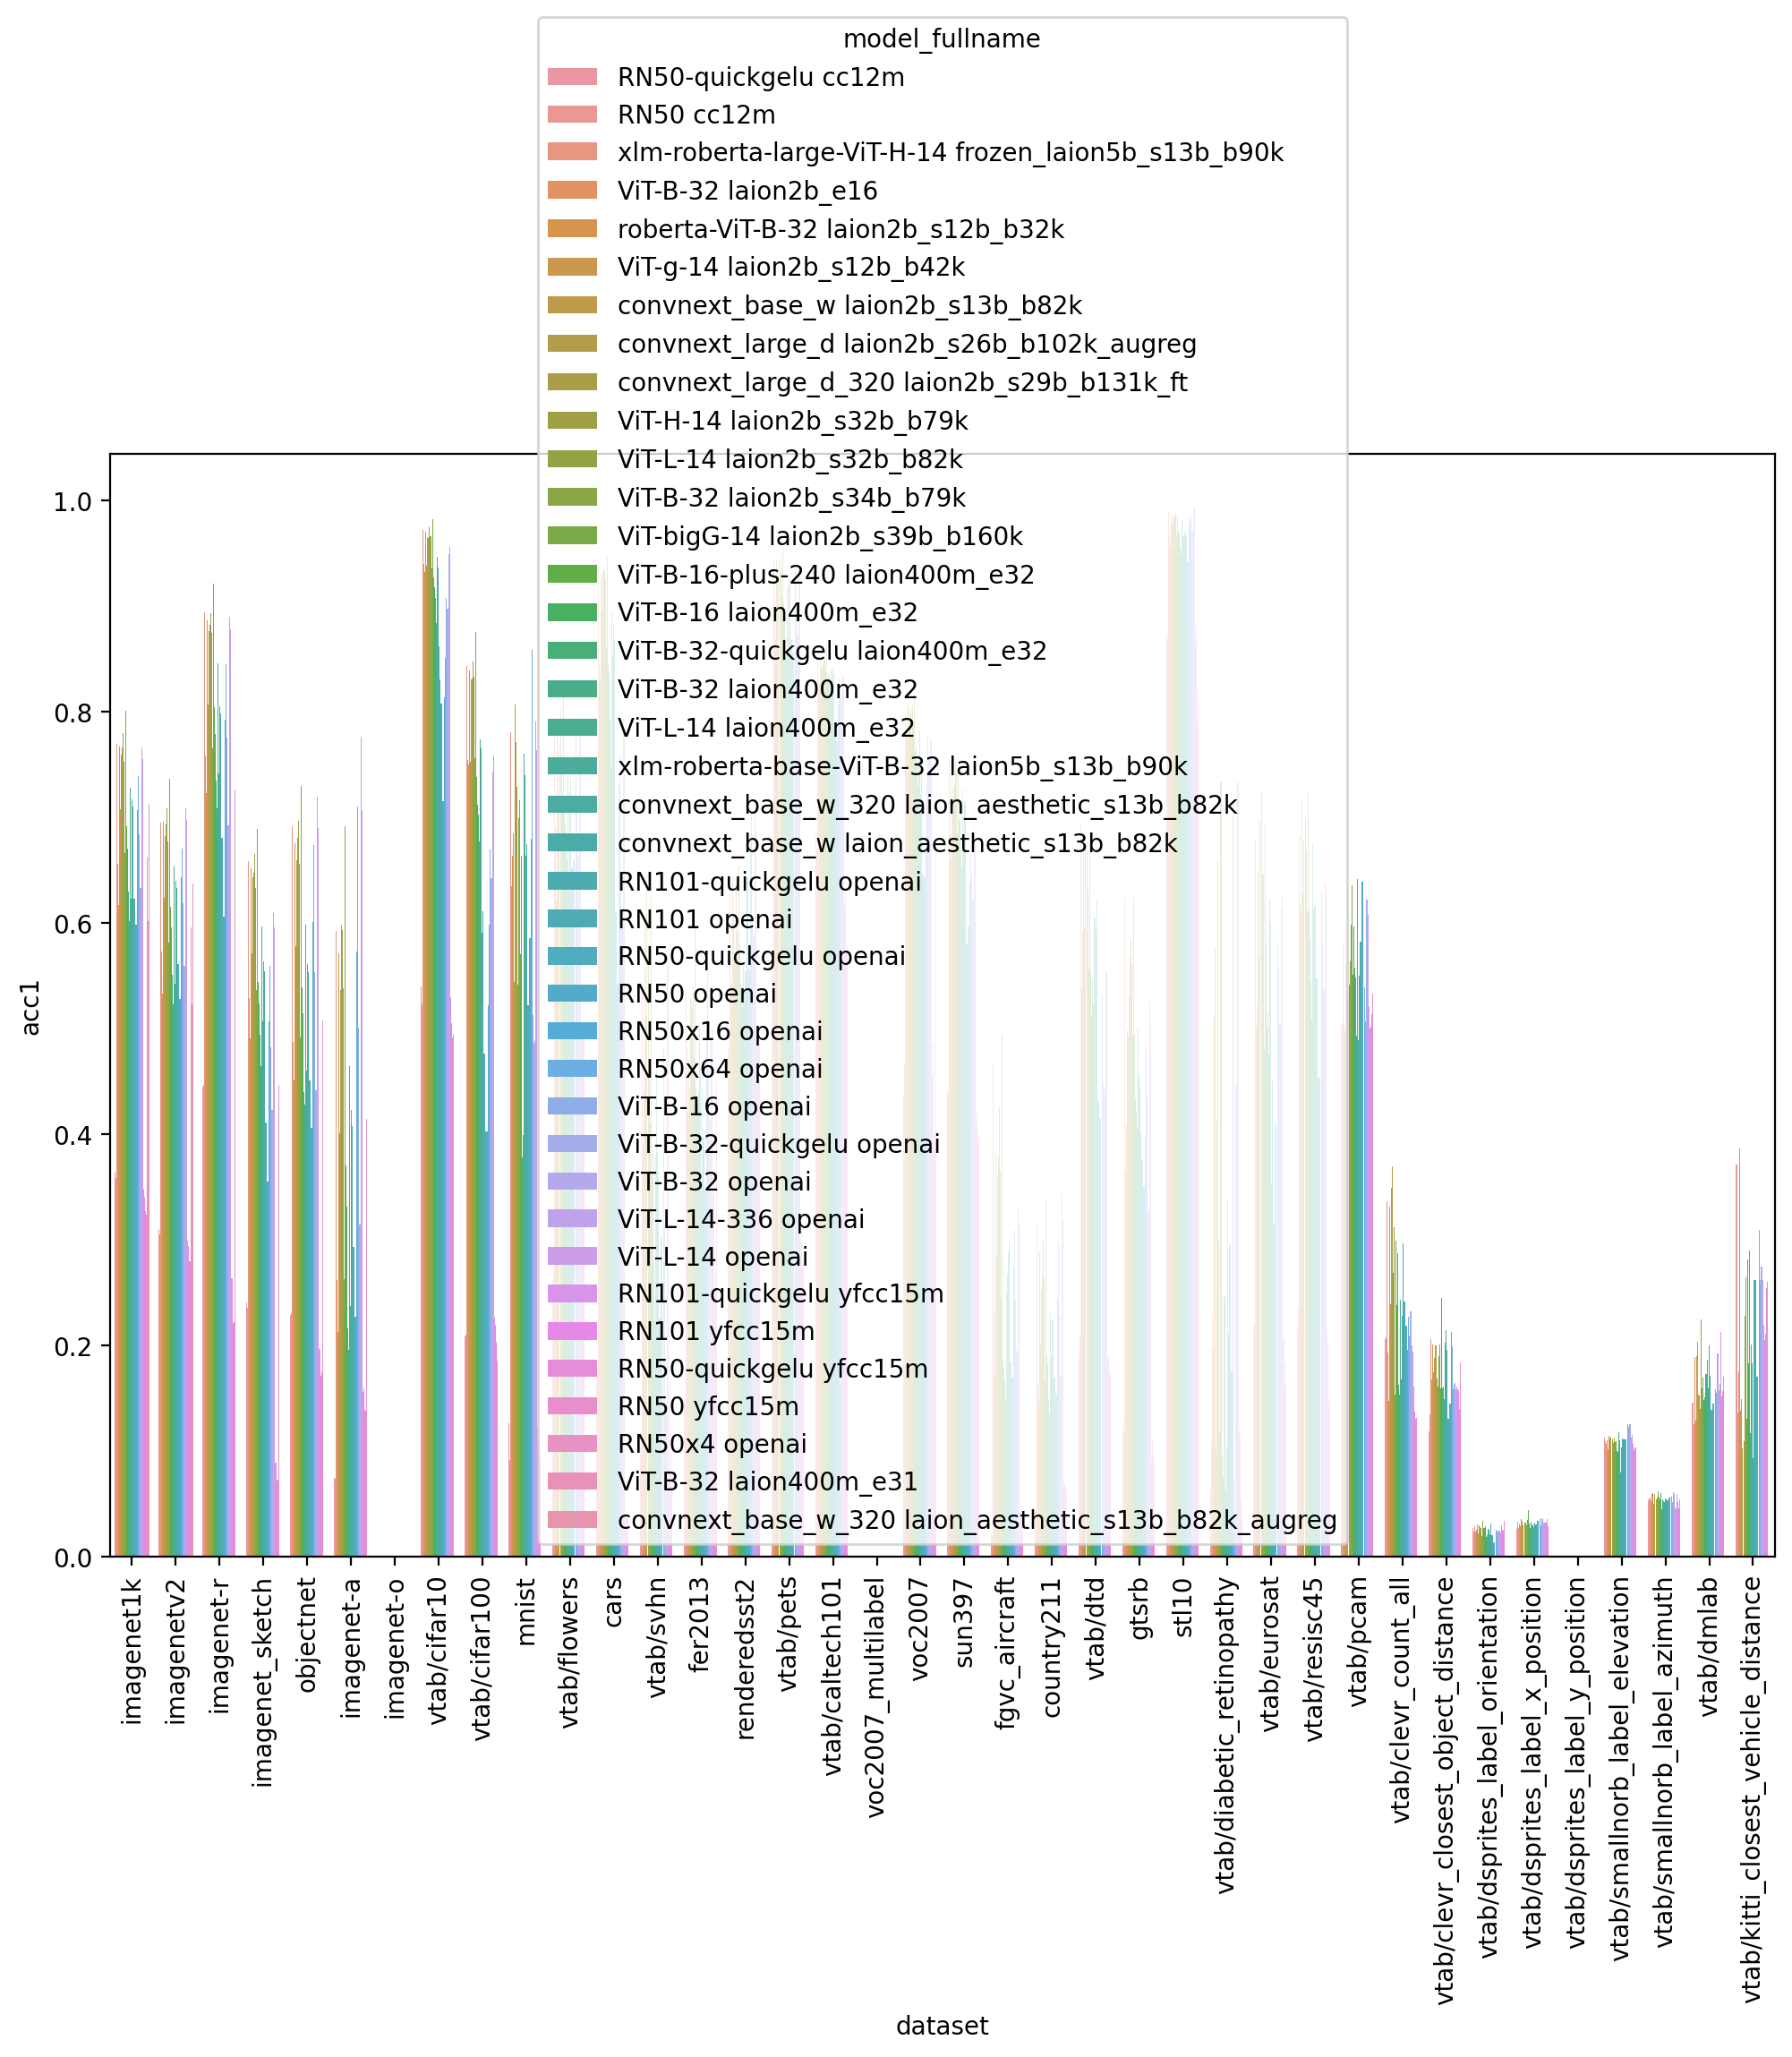

In [7]:
fig = plt.figure(figsize=(12,8))
#order = df.sort_values(by="dataset_type").dataset.unique()
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Zooming on a specific architecture

<Axes: xlabel='dataset', ylabel='acc1'>

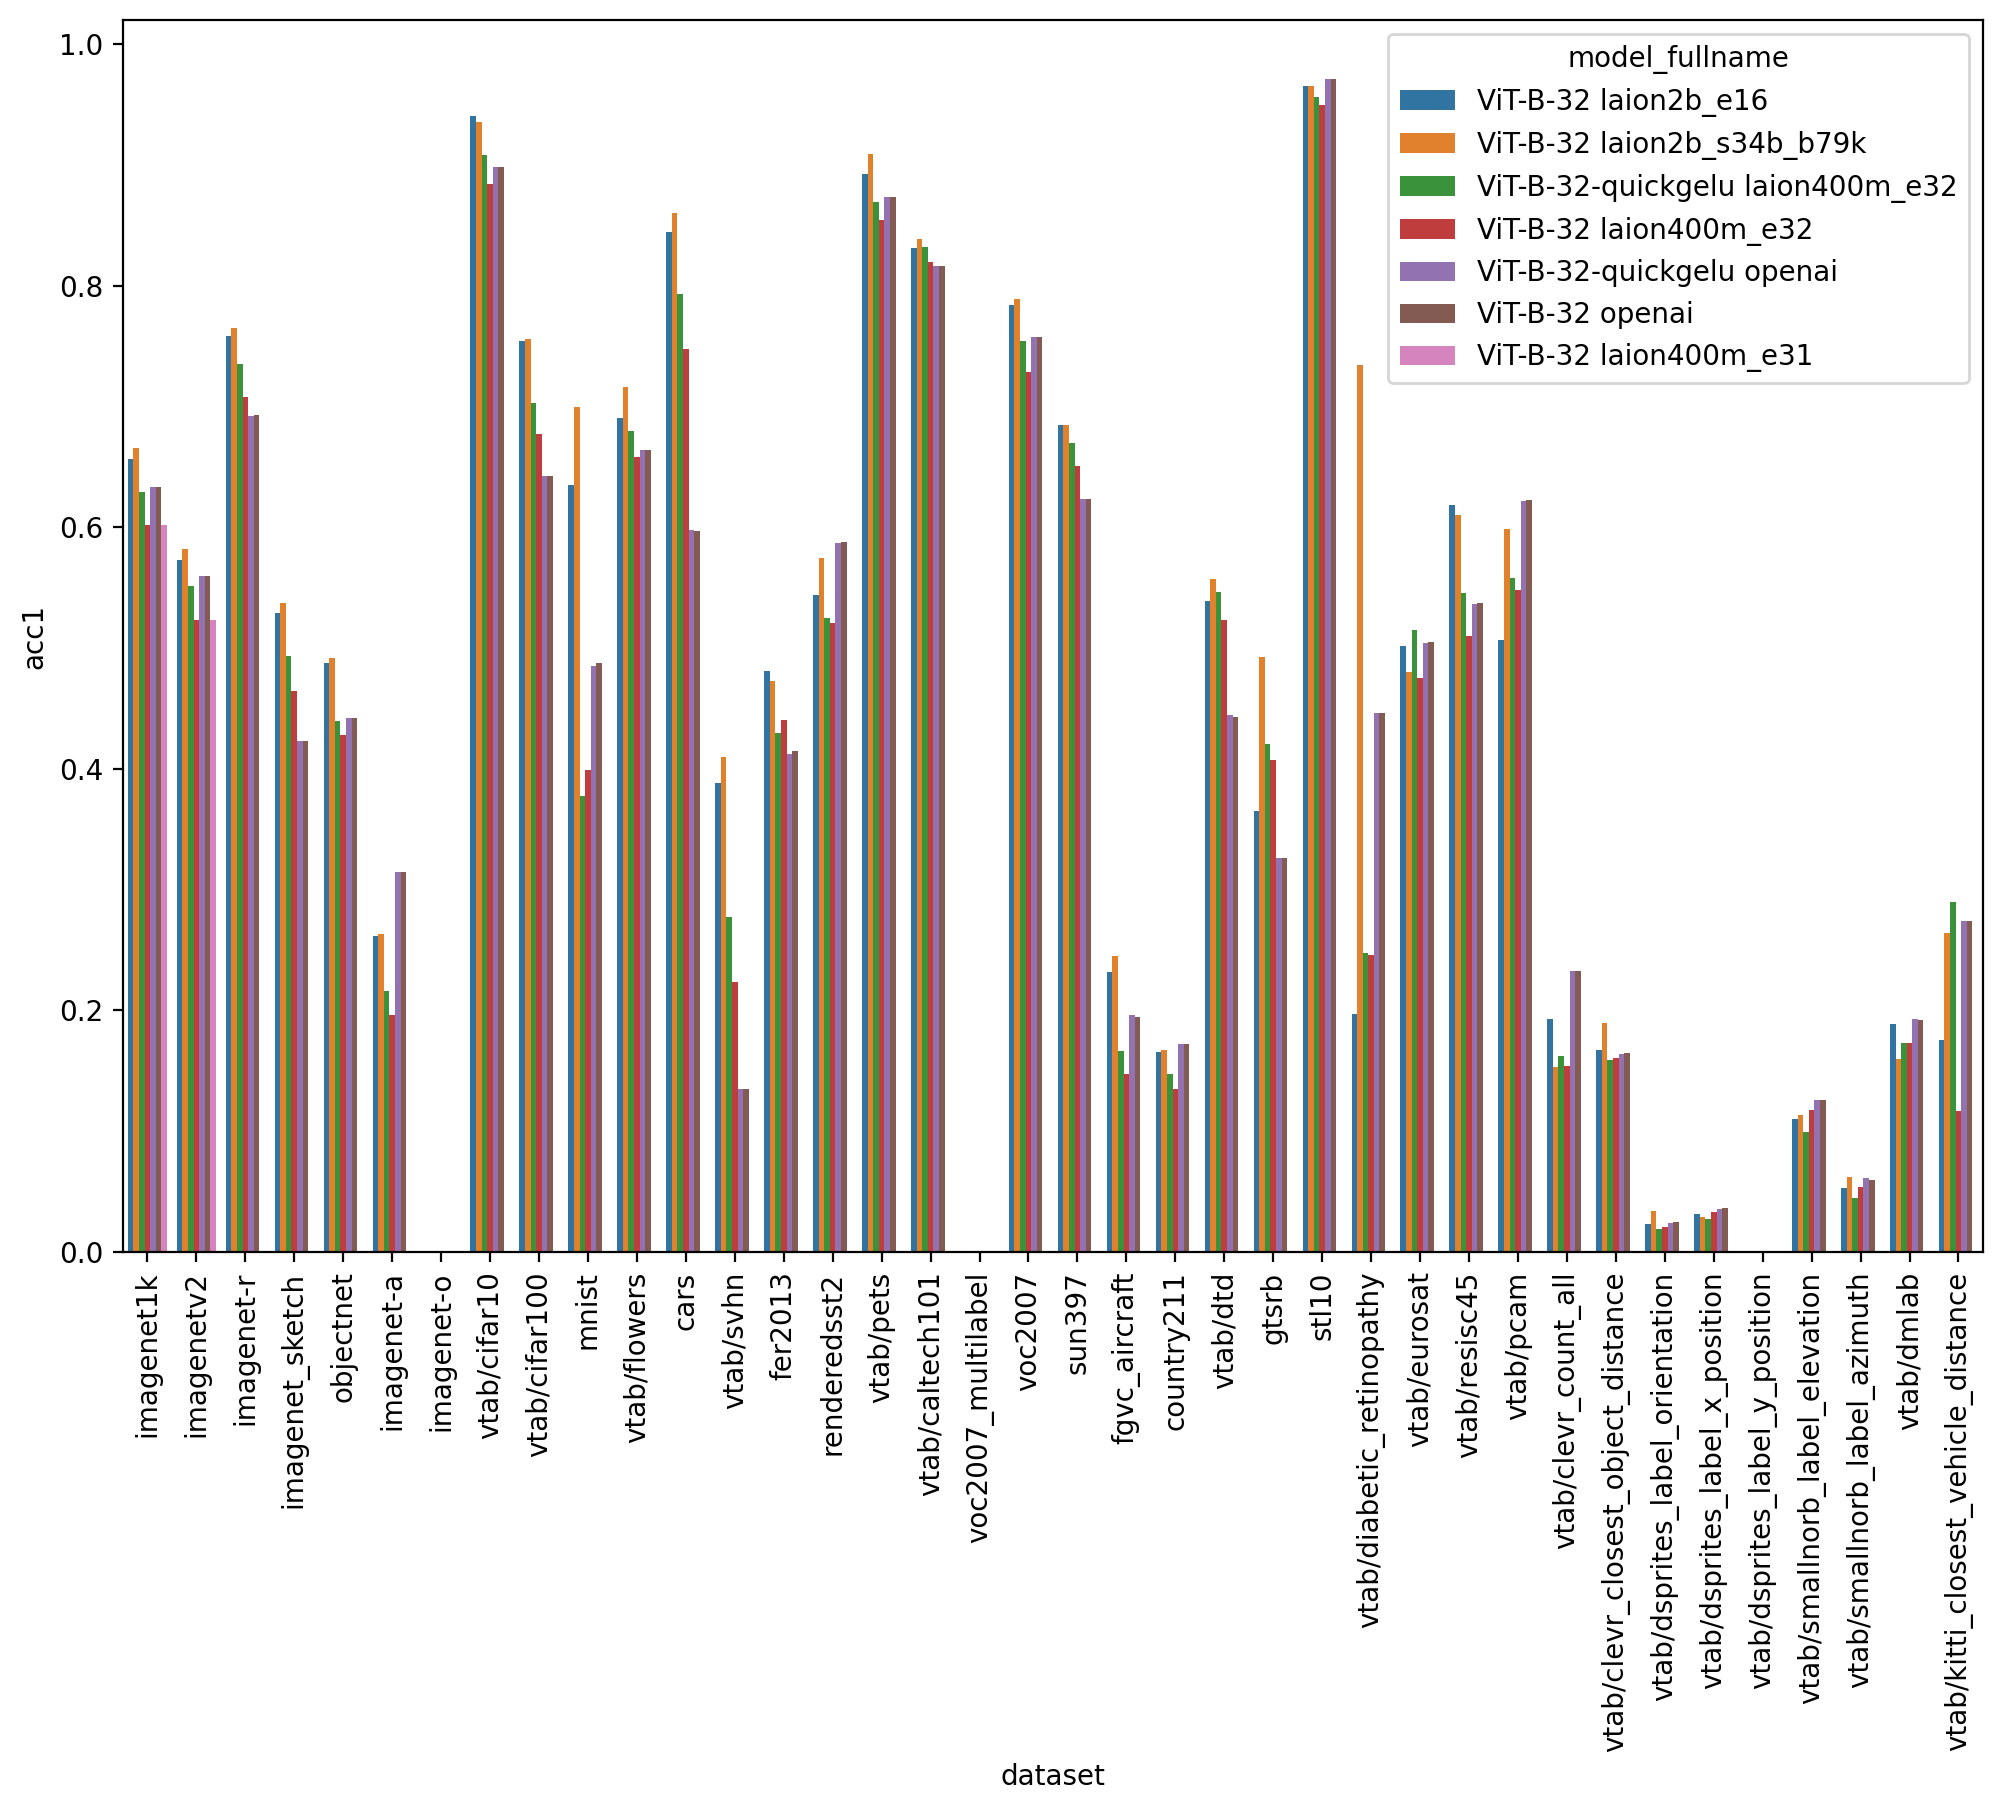

In [8]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df[df.model_arch=="ViT-B-32"]
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Accuracy averaged over all models for each dataset

/p/project/laionize/miniconda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/p/project/laionize/miniconda/lib/python3.10/site-packages/numpy-1.24.2-py3.10-linux-x86_64.egg/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<Axes: xlabel='dataset', ylabel='acc1'>

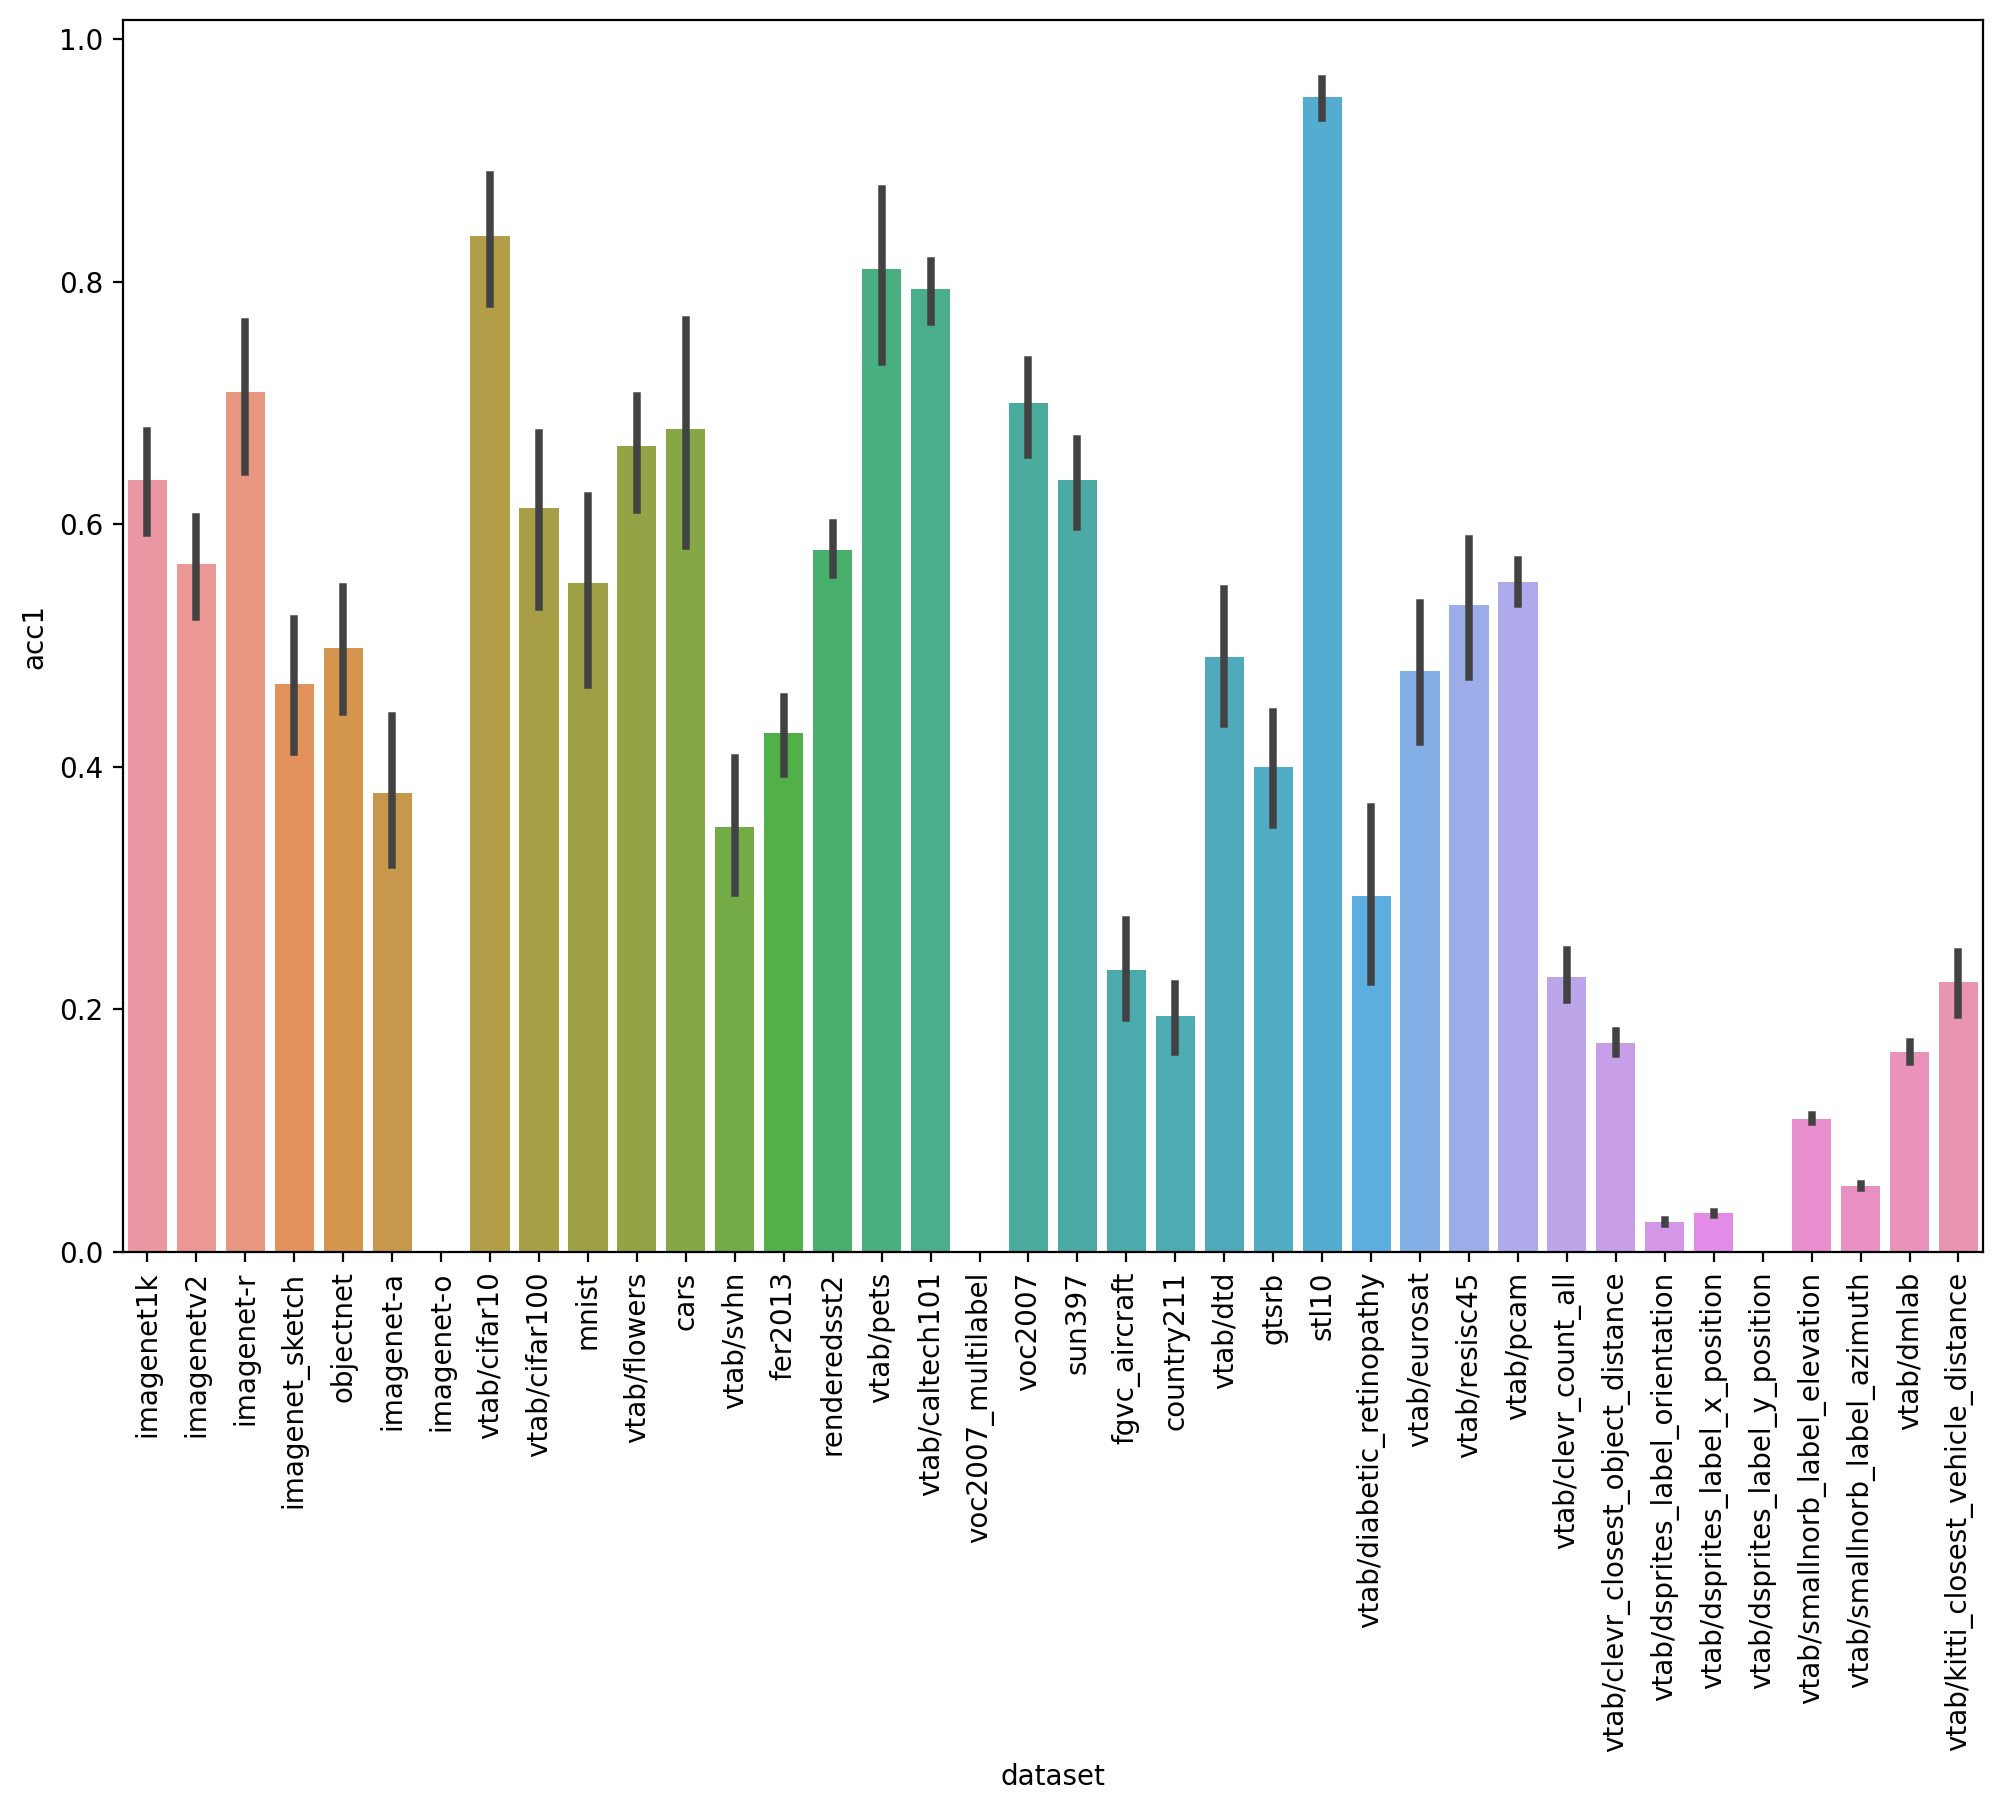

In [9]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", data=df,
    order=order
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Average accuracy on each dataset type for each model

/tmp/ipykernel_24146/3962520228.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


<Axes: xlabel='dataset_type', ylabel='acc1'>

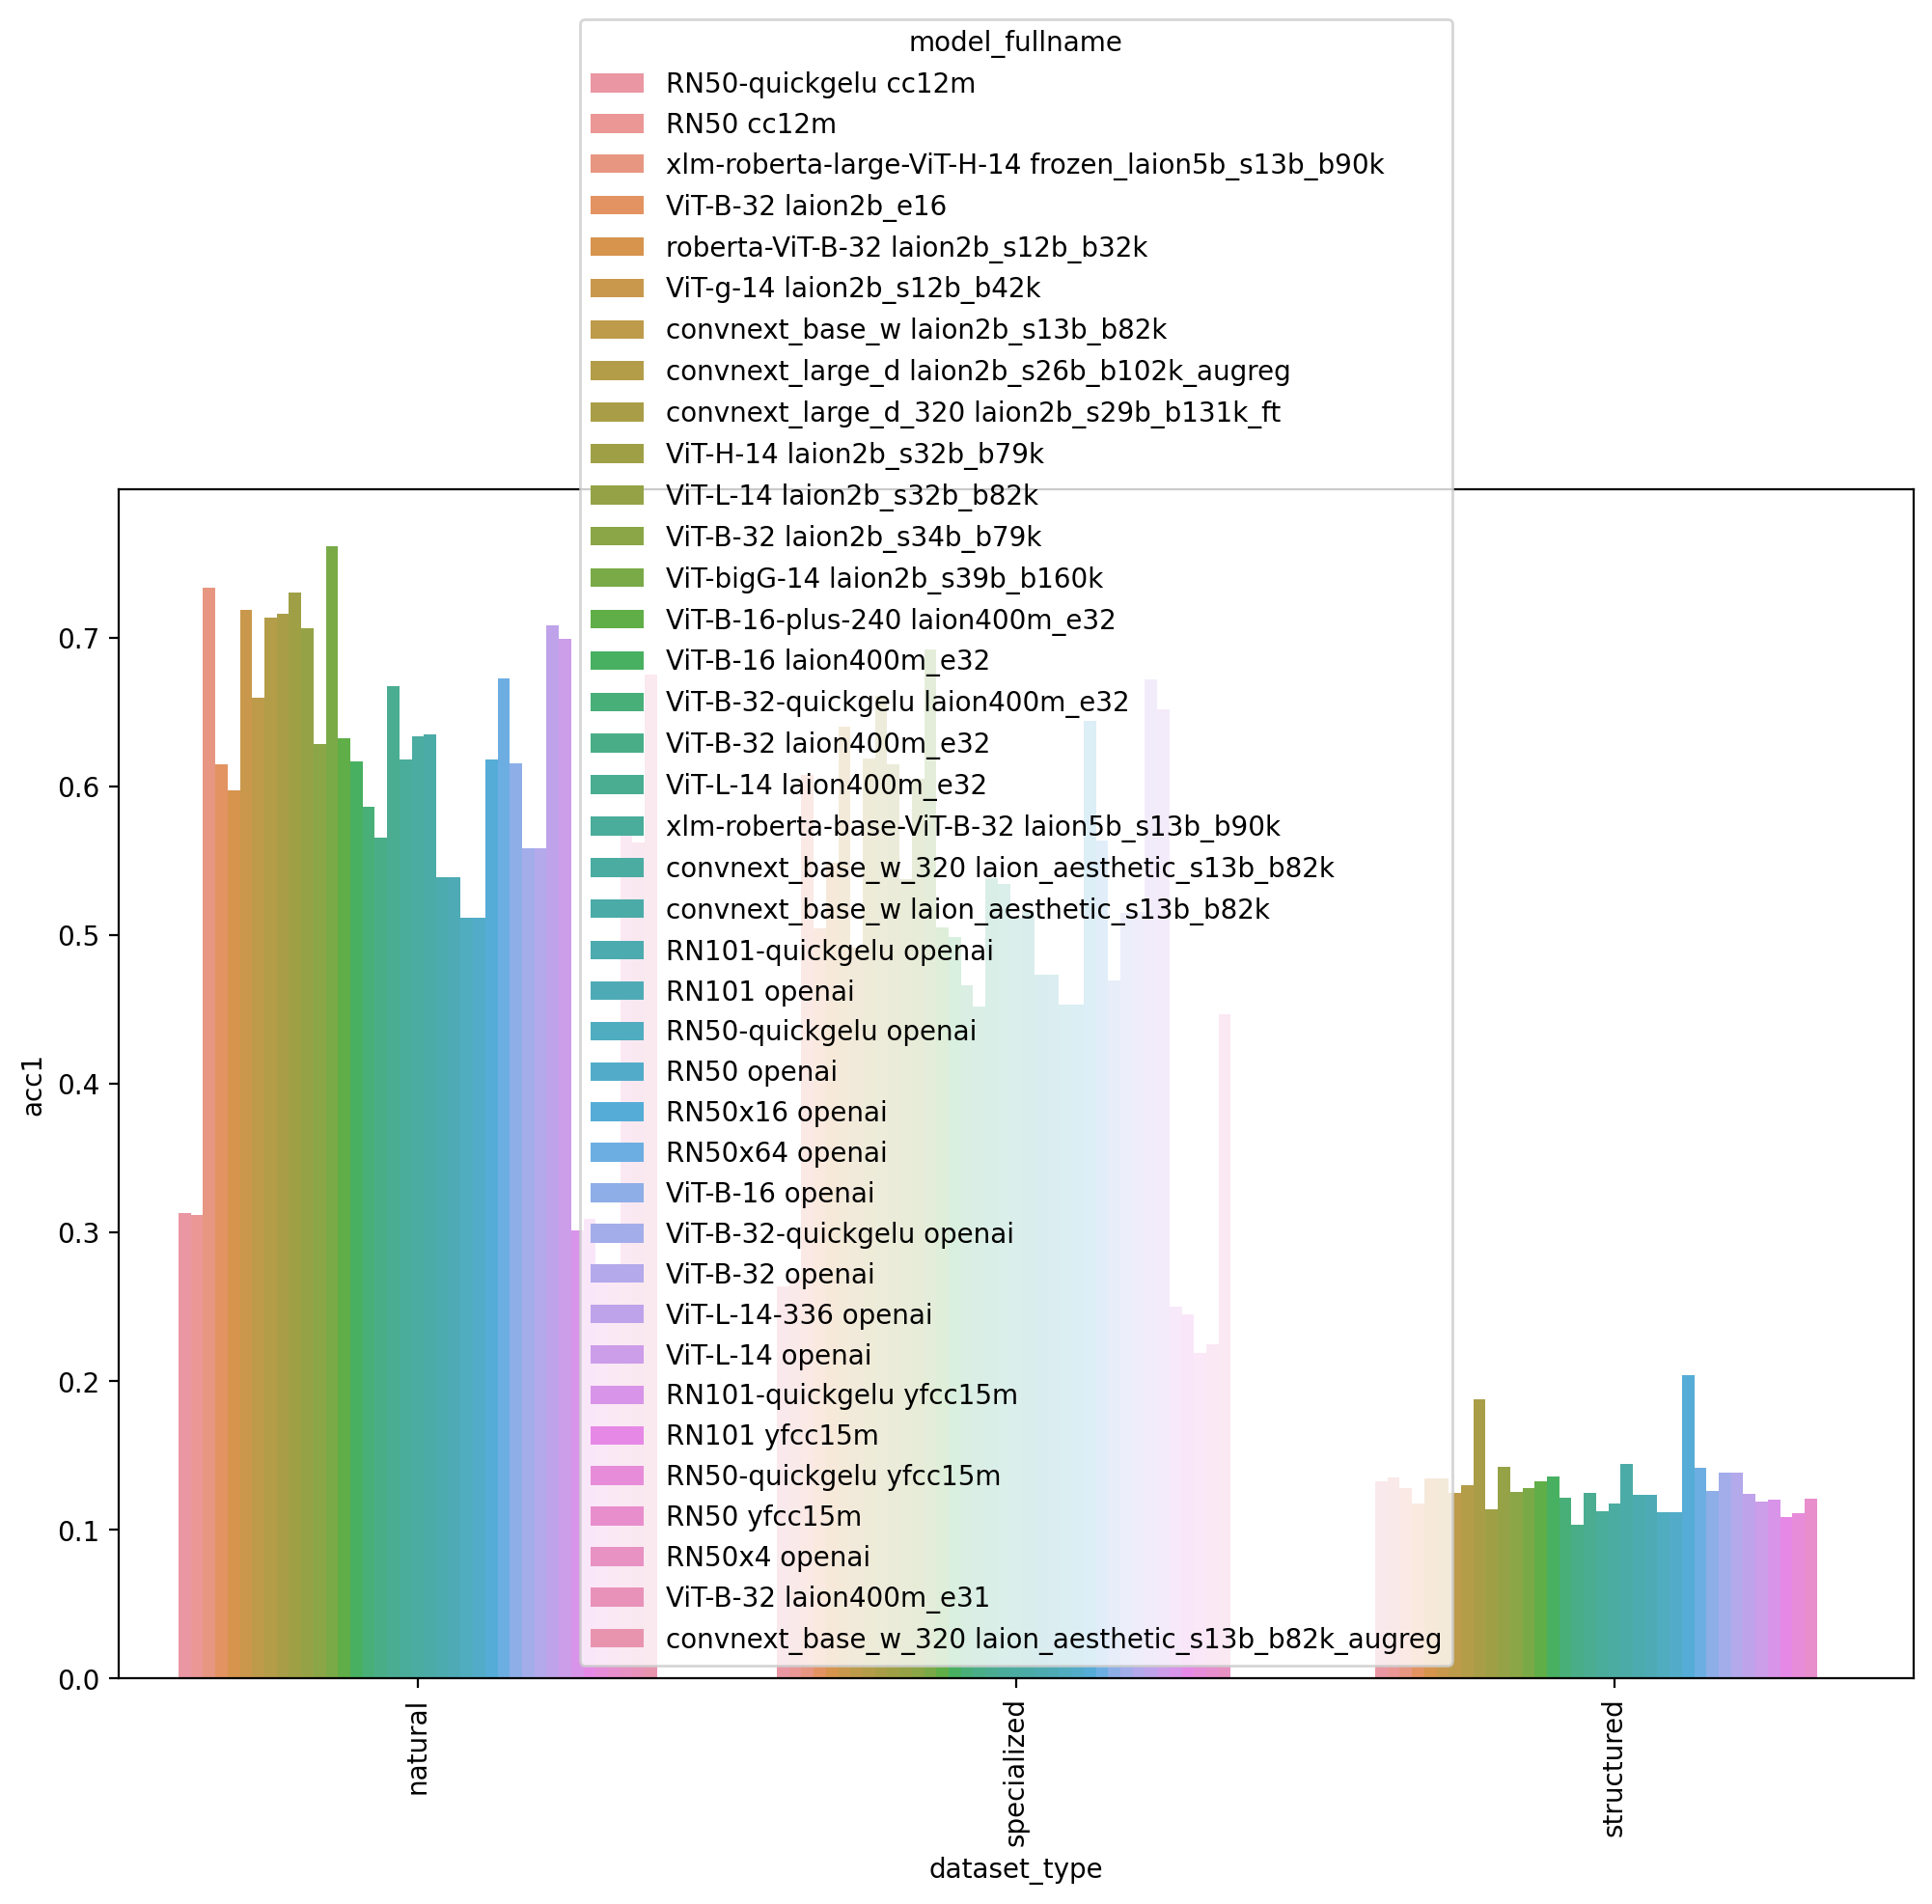

In [10]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset_type", y="acc1", 
    data=df,
    hue="model_fullname",
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over architecture for each dataset

/tmp/ipykernel_24146/1808378620.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


<Axes: xlabel='dataset', ylabel='acc1'>

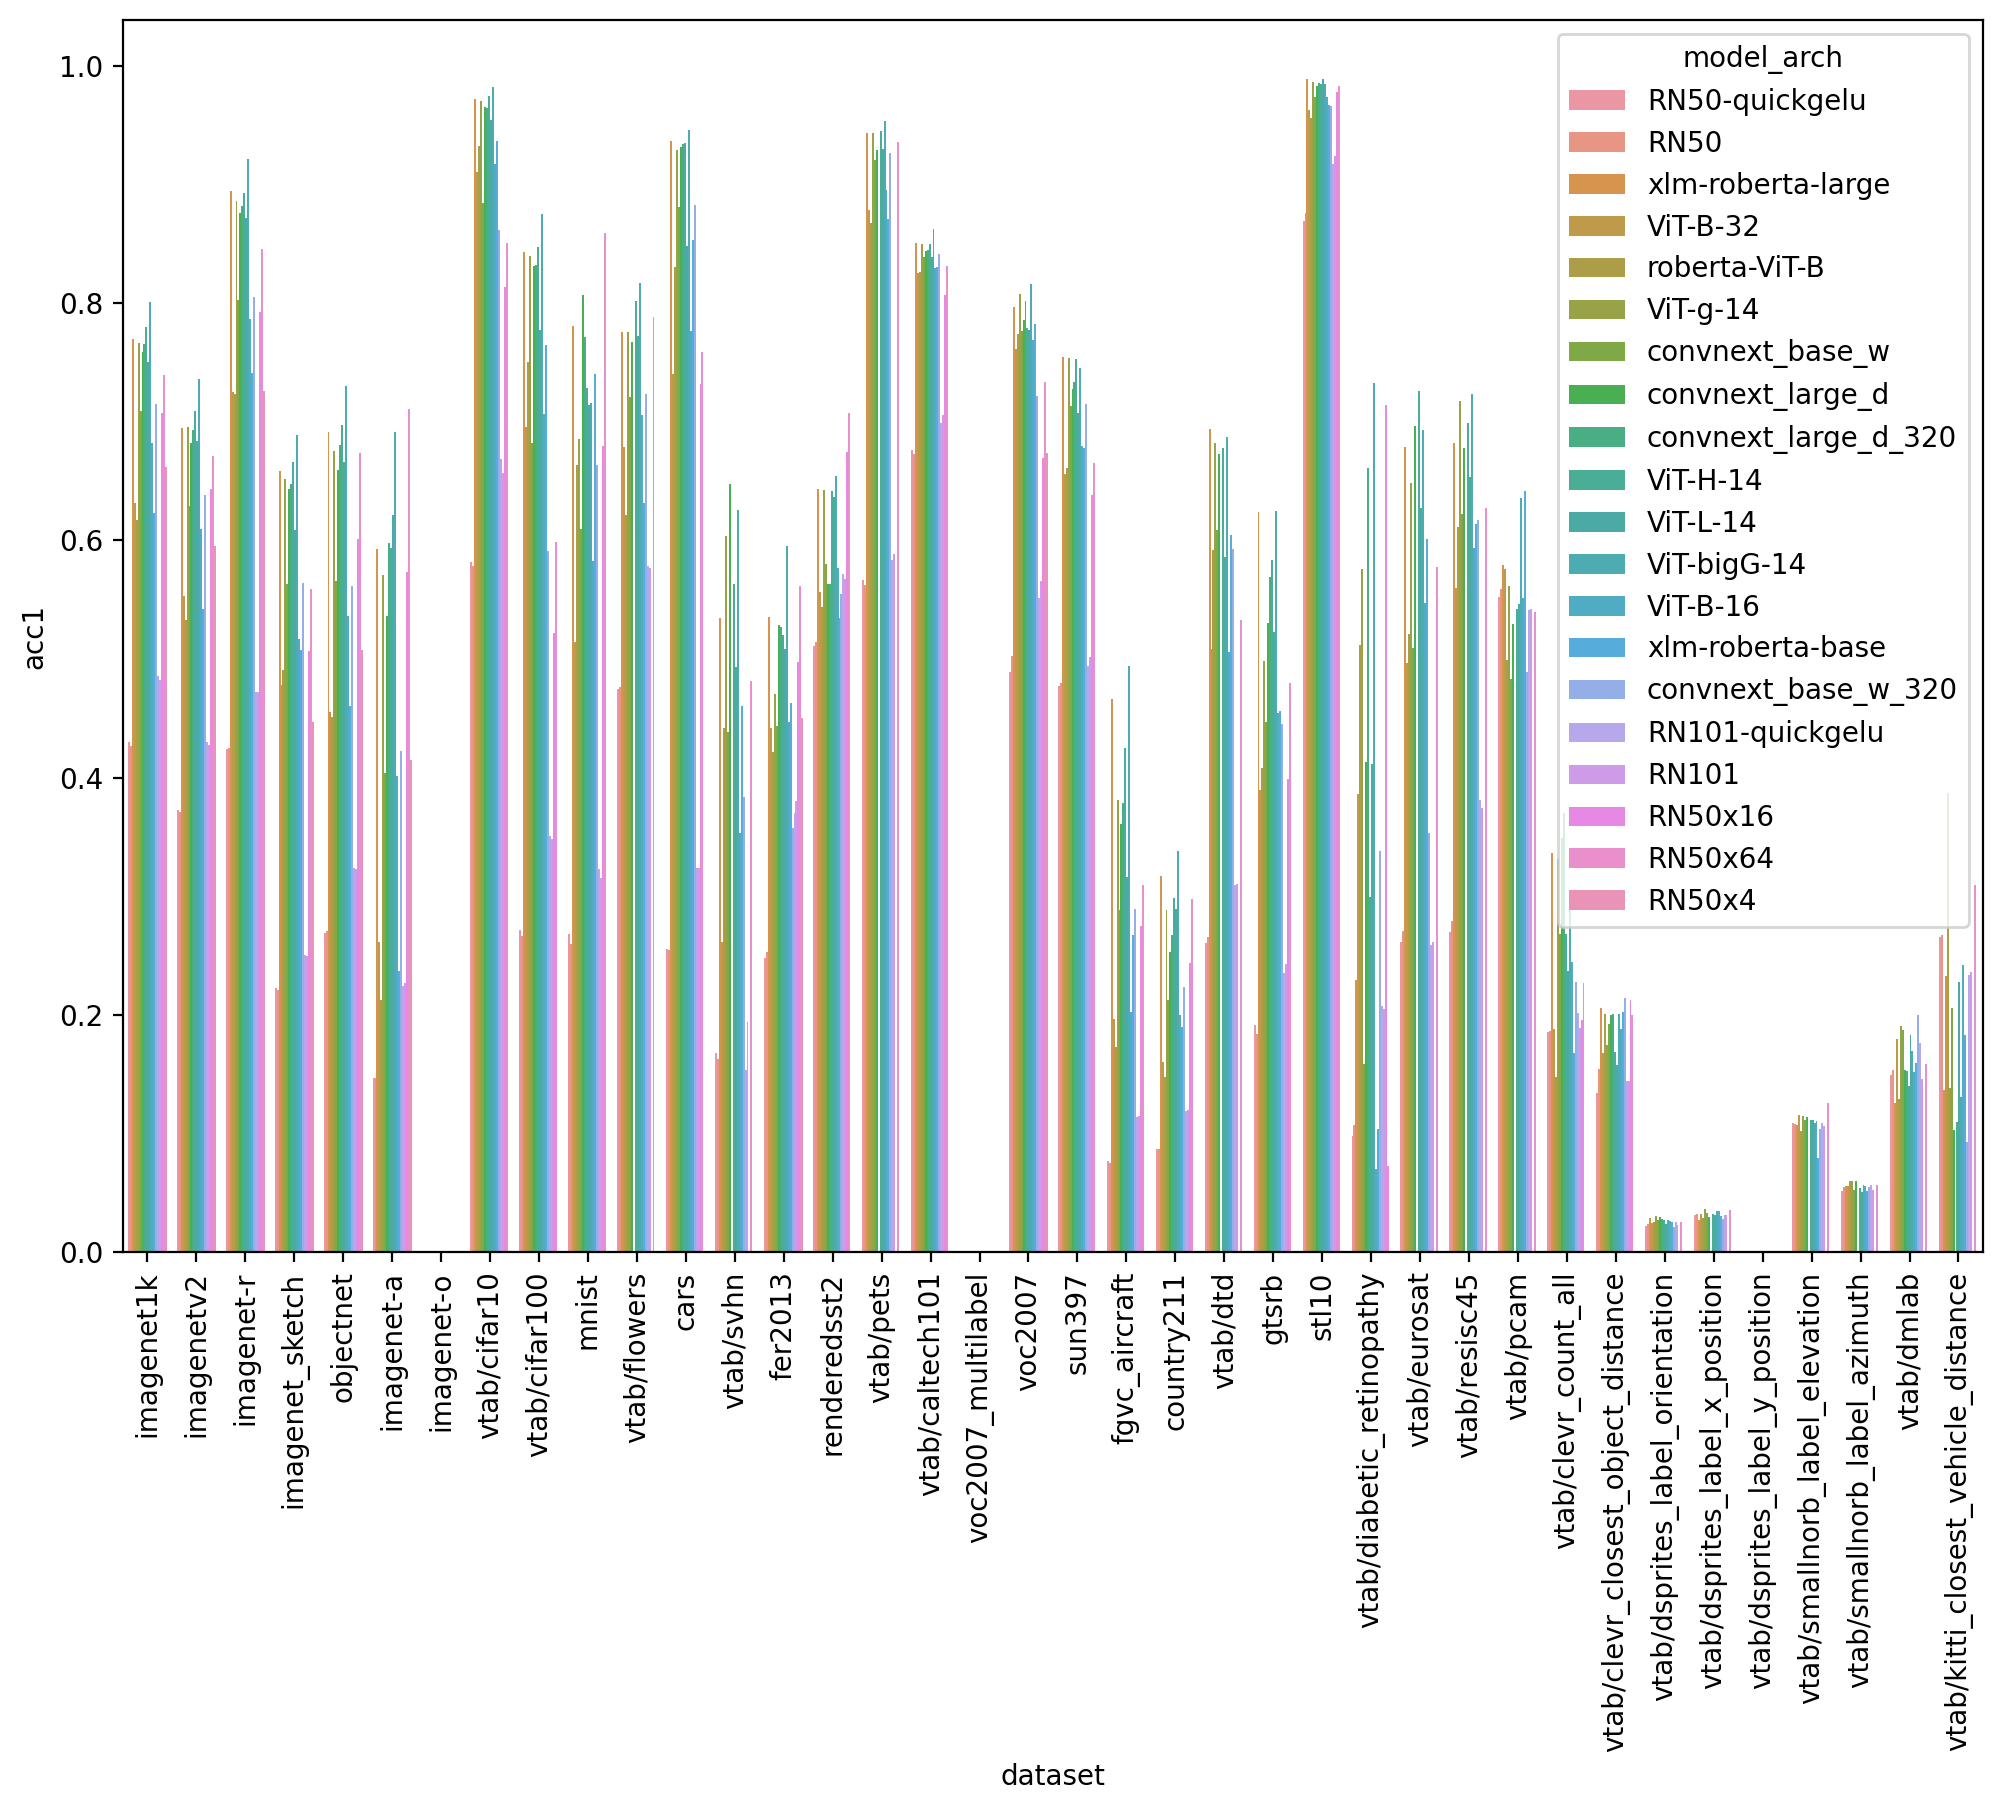

In [11]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_arch",
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over pre-training data source

/tmp/ipykernel_24146/2499478613.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


<Axes: xlabel='dataset', ylabel='acc1'>

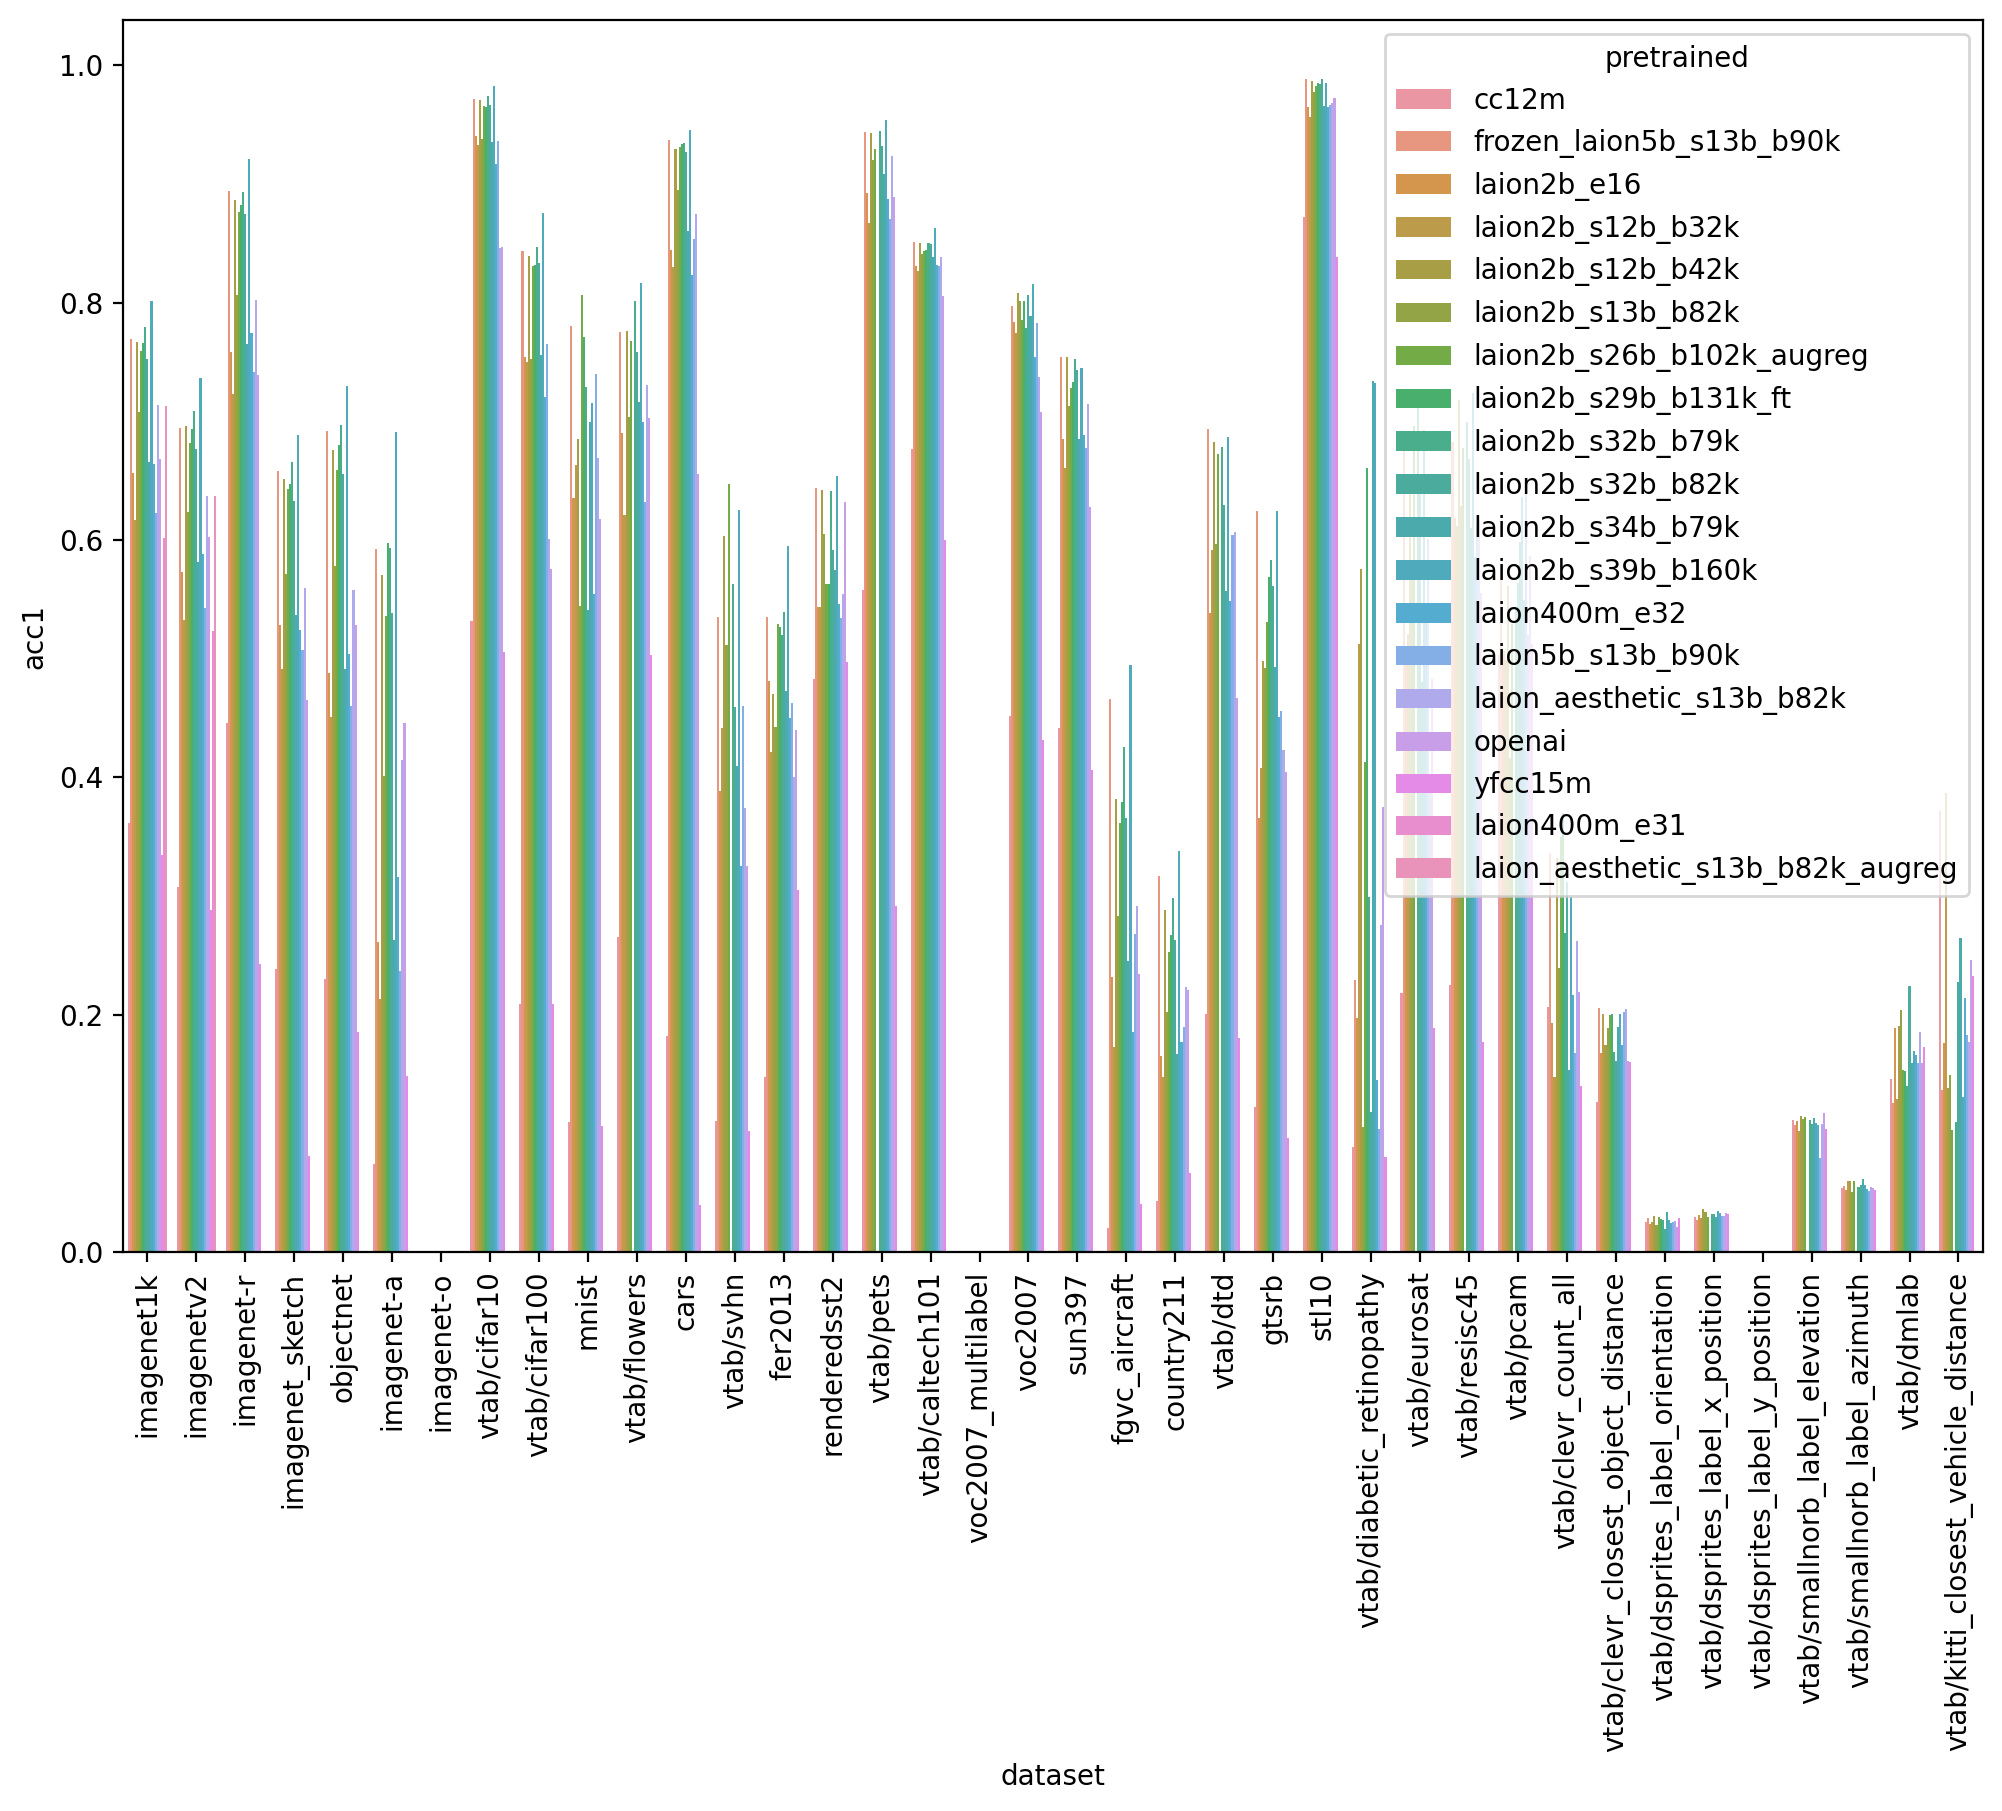

In [12]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained",
    ci=None,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Best results from each pre-training source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

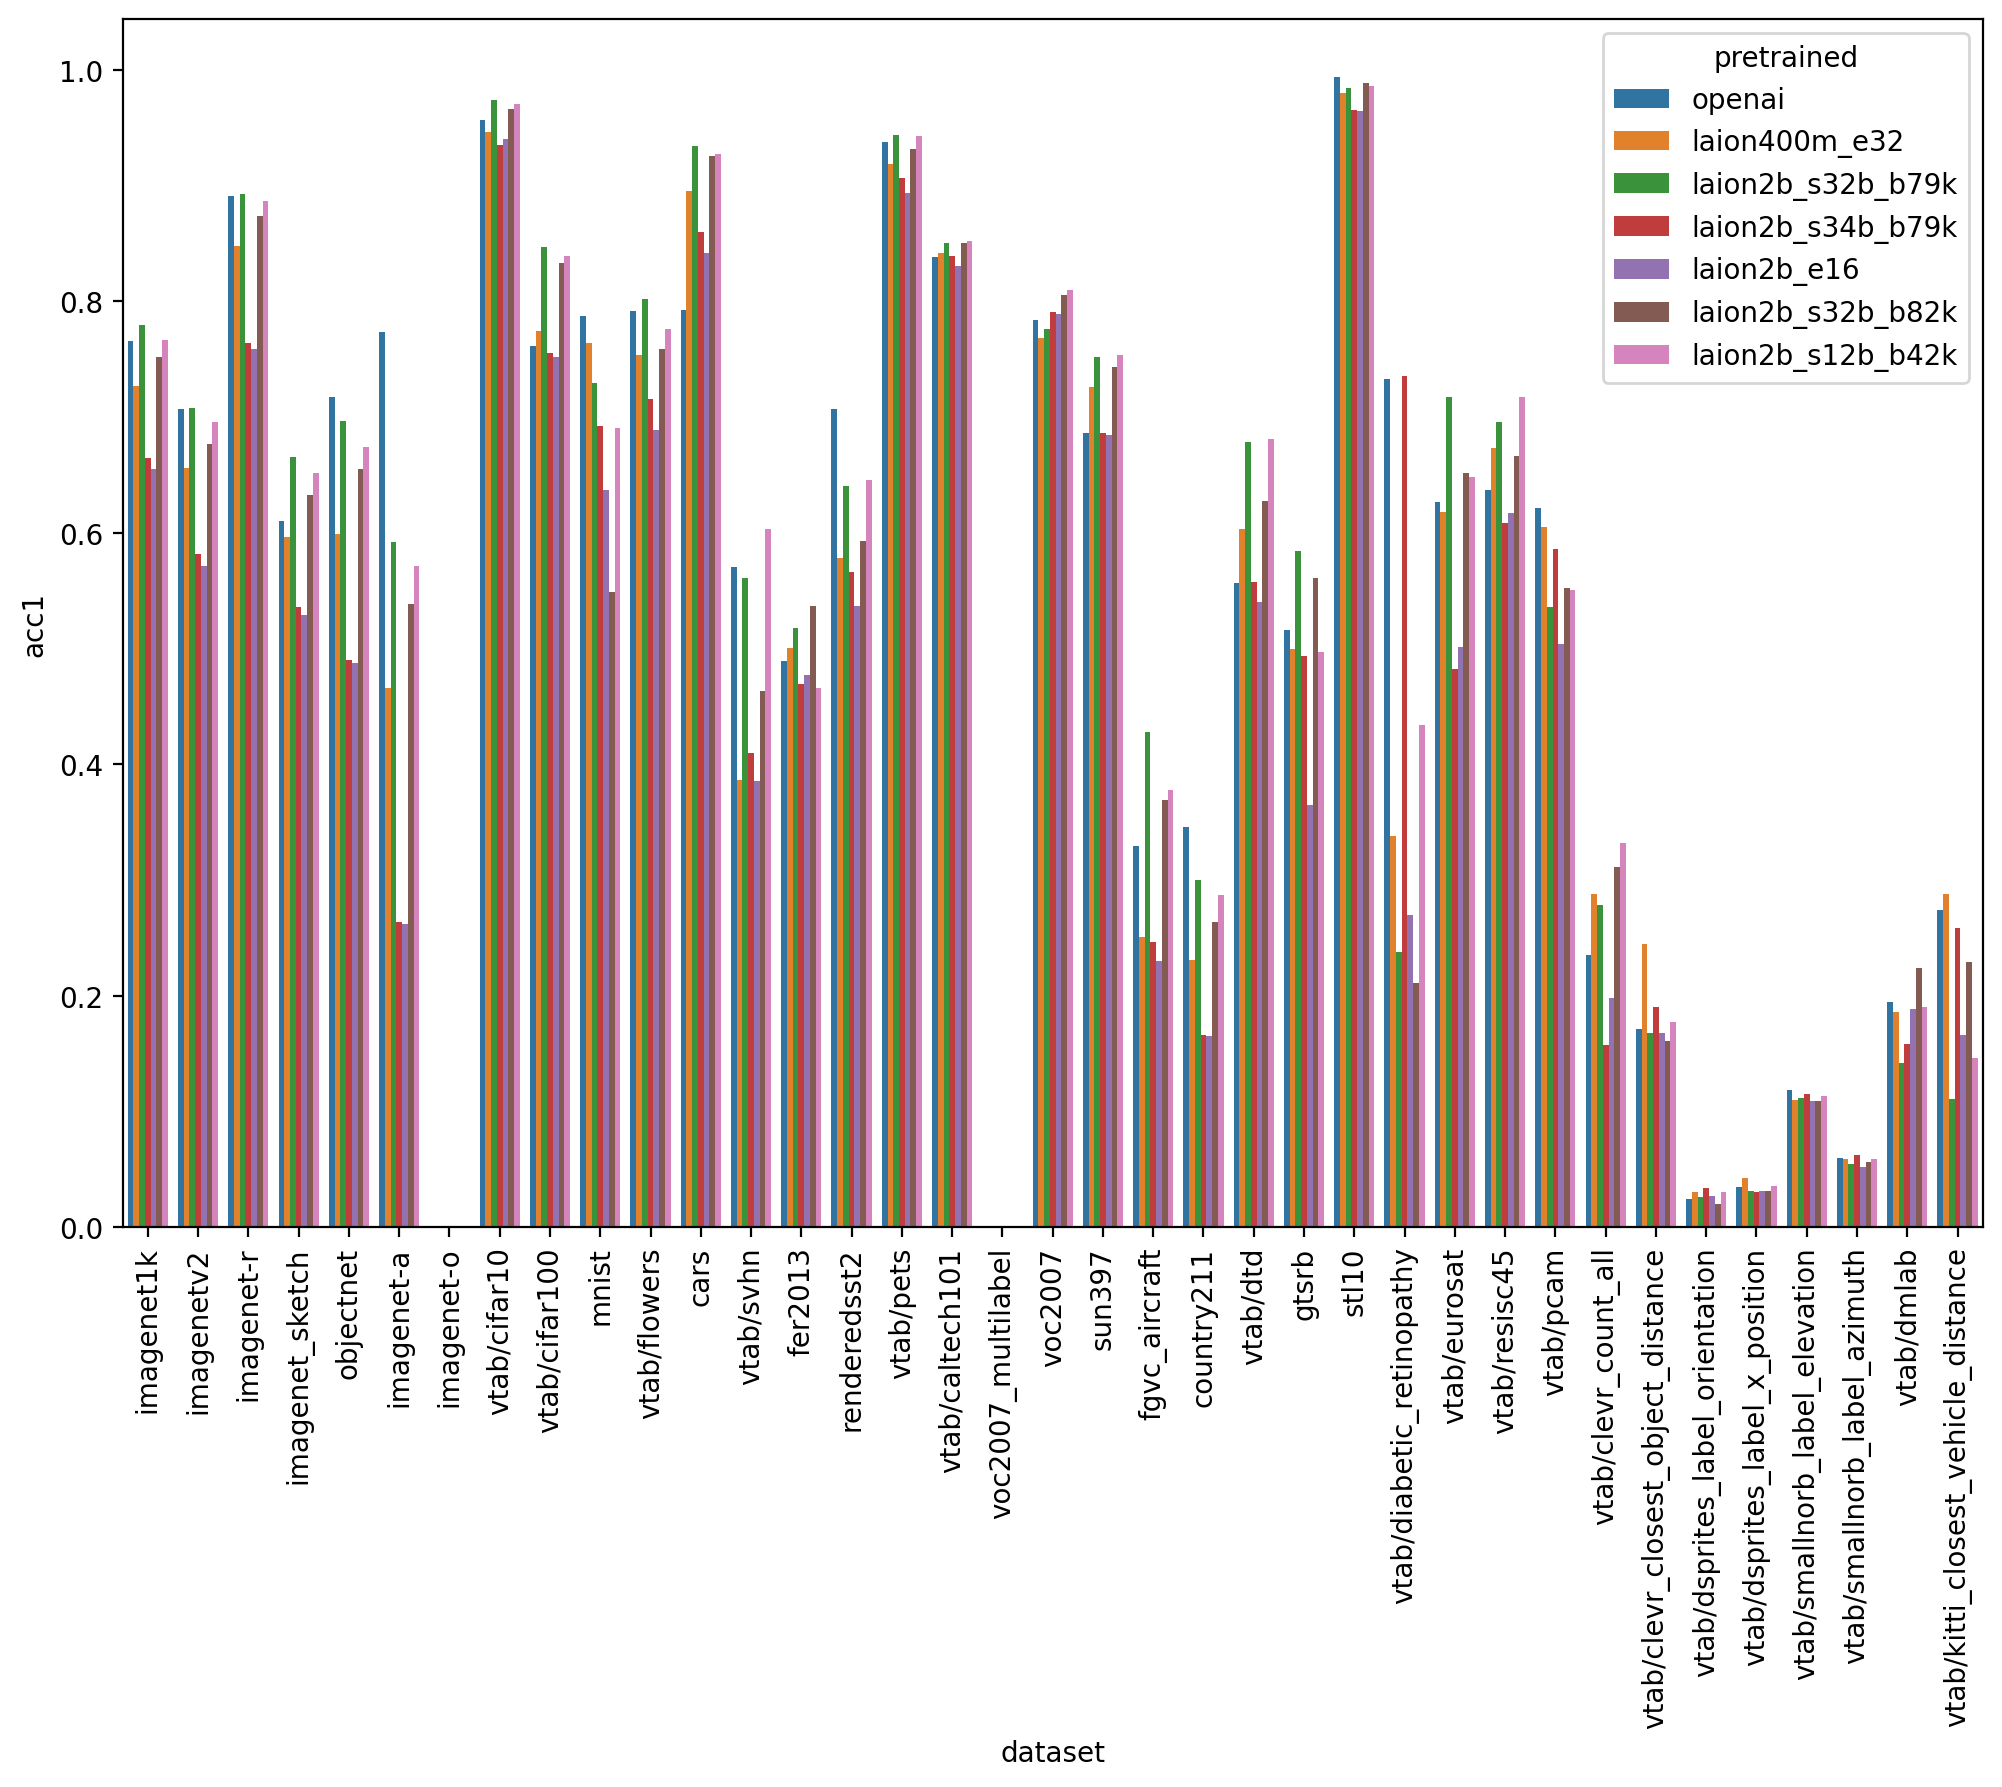

In [10]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained",
    estimator=np.max,
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Detailed results

### All results (acc1)

In [42]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric)#.T.dropna()
df_metric = df_metric.sort_values(by="imagenet1k")
df_metric

dataset,cars,country211,fer2013,fgvc_aircraft,gtsrb,imagenet-a,imagenet-r,imagenet1k,imagenet_sketch,imagenetv2,...,vtab/dtd,vtab/eurosat,vtab/flowers,vtab/kitti_closest_vehicle_distance,vtab/pcam,vtab/pets,vtab/resisc45,vtab/smallnorb_label_azimuth,vtab/smallnorb_label_elevation,vtab/svhn
model_fullname,,,,,,,,,,,,,,,,,,,,,
RN50 yfcc15m,0.042,0.064,0.269,0.038,0.084,0.138,0.222,0.323,0.073,0.280,...,0.174,0.182,0.501,0.260,0.533,0.280,0.149,0.054,0.104,0.068
RN50-quickgelu yfcc15m,0.041,0.064,0.247,0.038,0.096,0.139,0.222,0.327,0.072,0.280,...,0.172,0.161,0.504,0.255,0.513,0.278,0.142,0.045,0.103,0.097
RN101 yfcc15m,0.038,0.070,0.362,0.044,0.109,0.160,0.264,0.341,0.089,0.294,...,0.189,0.208,0.502,0.211,0.501,0.309,0.202,0.052,0.101,0.161
RN101-quickgelu yfcc15m,0.037,0.068,0.342,0.043,0.094,0.156,0.263,0.349,0.089,0.299,...,0.186,0.203,0.504,0.205,0.500,0.298,0.214,0.059,0.106,0.082
RN50 cc12m,0.179,0.042,0.144,0.018,0.116,0.074,0.446,0.359,0.235,0.305,...,0.208,0.221,0.269,0.371,0.504,0.551,0.236,0.055,0.110,0.118
RN50-quickgelu cc12m,0.184,0.043,0.150,0.022,0.128,0.075,0.445,0.365,0.241,0.310,...,0.193,0.215,0.262,0.371,0.503,0.566,0.214,0.054,0.113,0.103
RN50 openai,0.543,0.154,0.346,0.170,0.351,0.227,0.606,0.598,0.355,0.528,...,0.415,0.409,0.660,0.170,0.639,0.856,0.453,0.056,0.111,0.302
RN50-quickgelu openai,0.543,0.154,0.346,0.170,0.351,0.227,0.606,0.598,0.355,0.528,...,0.415,0.409,0.660,0.170,0.639,0.856,0.453,0.056,0.111,0.302
ViT-B-32 laion400m_e31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.602,NaN,0.523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
metric = "mean_per_class_recall"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric)#.T.dropna()
df_metric

dataset,cars,country211,fer2013,fgvc_aircraft,gtsrb,imagenet-a,imagenet-r,imagenet1k,imagenet_sketch,imagenetv2,...,vtab/dtd,vtab/eurosat,vtab/flowers,vtab/kitti_closest_vehicle_distance,vtab/pcam,vtab/pets,vtab/resisc45,vtab/smallnorb_label_azimuth,vtab/smallnorb_label_elevation,vtab/svhn
model_fullname,,,,,,,,,,,,,,,,,,,,,
RN101 openai,0.612,0.169,0.368,0.184,0.295,0.310,0.664,0.623,0.411,0.562,...,0.434,0.320,0.654,0.283,0.582,0.865,0.555,0.054,0.114,0.251
RN101 yfcc15m,0.038,0.070,0.274,0.044,0.110,0.150,0.245,0.340,0.089,0.295,...,0.189,0.202,0.489,0.232,0.502,0.307,0.201,0.052,0.102,0.111
RN101-quickgelu openai,0.612,0.169,0.368,0.184,0.295,0.310,0.664,0.623,0.411,0.562,...,0.434,0.320,0.654,0.283,0.582,0.865,0.555,0.054,0.114,0.251
RN101-quickgelu yfcc15m,0.037,0.068,0.236,0.042,0.103,0.149,0.245,0.349,0.089,0.300,...,0.186,0.200,0.494,0.225,0.501,0.296,0.216,0.059,0.106,0.102
RN50 cc12m,0.182,0.042,0.142,0.018,0.105,0.087,0.426,0.359,0.235,0.305,...,0.207,0.221,0.247,0.407,0.504,0.550,0.237,0.056,0.109,0.096
RN50 openai,0.545,0.154,0.317,0.170,0.258,0.240,0.598,0.598,0.355,0.528,...,0.415,0.412,0.653,0.242,0.639,0.853,0.456,0.057,0.110,0.249
RN50 yfcc15m,0.041,0.064,0.239,0.037,0.094,0.132,0.208,0.323,0.073,0.280,...,0.174,0.177,0.468,0.319,0.534,0.278,0.150,0.054,0.104,0.101
RN50-quickgelu cc12m,0.186,0.043,0.147,0.022,0.101,0.087,0.429,0.364,0.241,0.310,...,0.191,0.213,0.237,0.407,0.504,0.566,0.216,0.055,0.112,0.094
RN50-quickgelu openai,0.545,0.154,0.317,0.170,0.258,0.240,0.598,0.598,0.355,0.528,...,0.415,0.412,0.653,0.242,0.639,0.853,0.456,0.057,0.110,0.249


### Imagenet robustness results (acc1)

In [39]:
# Imagenet robustness results
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric)#.T.dropna()
df_metric[(df_metric.index.str.startswith("imagenet")) | (df_metric.index=="objectnet")]

dataset,cars,country211,fer2013,fgvc_aircraft,gtsrb,imagenet-a,imagenet-r,imagenet1k,imagenet_sketch,imagenetv2,...,vtab/dtd,vtab/eurosat,vtab/flowers,vtab/kitti_closest_vehicle_distance,vtab/pcam,vtab/pets,vtab/resisc45,vtab/smallnorb_label_azimuth,vtab/smallnorb_label_elevation,vtab/svhn
model_fullname,,,,,,,,,,,,,,,,,,,,,


# Robustness plot

Here, following "Measuring Robustness to Natural Distribution Shifts
in Image Classification" (https://arxiv.org/pdf/2007.00644.pdf, https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py),
we show  the deviation from the line fit of (x=imagenet1k accuracy, y=imagenetv2/imagenet-1/imagenet_sketch) which was used
to measure robustnest improvements separately from accuracy improvements in imagenet1k, as the two are correlated.

In the plot below, deviation from the line are improvements in robustness.

Text(0, 0.5, 'imagenetv2 top-1 accuracy (%)')

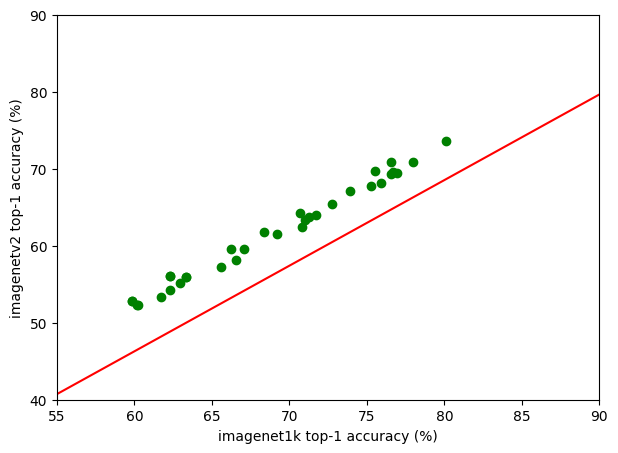

In [28]:
plt.figure(figsize=(7, 5),dpi=100)
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values="acc1").T.dropna()
dataset = "imagenetv2"
line_fits_data = {
    # slopes and intercepts from https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py
    "imagenetv2": (1.112, -20.433),
    "imagenet-r": (1.549, -104.556),
    "imagenet_sketch": (0.931, -45.373)
}
x=np.linspace(0, 100,100)
slope, intercept = line_fits_data[dataset]
y=x*slope+intercept
plt.xlim(55,90)
plt.ylim(40,90)
d = df_metric.T[["imagenet1k", dataset]]*100
plt.scatter(d["imagenet1k"], d[dataset], color="green")
plt.plot(x,y, color="red")
plt.xlabel("imagenet1k top-1 accuracy (%)")
plt.ylabel(f"{dataset} top-1 accuracy (%)")

### All results (mean_per_class_recall)

In [36]:
metric = "mean_per_class_recall"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric)#.T.dropna()

dataset,cars,country211,fer2013,fgvc_aircraft,gtsrb,imagenet-a,imagenet-r,imagenet1k,imagenet_sketch,imagenetv2,...,vtab/dtd,vtab/eurosat,vtab/flowers,vtab/kitti_closest_vehicle_distance,vtab/pcam,vtab/pets,vtab/resisc45,vtab/smallnorb_label_azimuth,vtab/smallnorb_label_elevation,vtab/svhn
model_fullname,,,,,,,,,,,,,,,,,,,,,
RN101 openai,0.612,0.169,0.368,0.184,0.295,0.310,0.664,0.623,0.411,0.562,...,0.434,0.320,0.654,0.283,0.582,0.865,0.555,0.054,0.114,0.251
RN101 yfcc15m,0.038,0.070,0.274,0.044,0.110,0.150,0.245,0.340,0.089,0.295,...,0.189,0.202,0.489,0.232,0.502,0.307,0.201,0.052,0.102,0.111
RN101-quickgelu openai,0.612,0.169,0.368,0.184,0.295,0.310,0.664,0.623,0.411,0.562,...,0.434,0.320,0.654,0.283,0.582,0.865,0.555,0.054,0.114,0.251
RN101-quickgelu yfcc15m,0.037,0.068,0.236,0.042,0.103,0.149,0.245,0.349,0.089,0.300,...,0.186,0.200,0.494,0.225,0.501,0.296,0.216,0.059,0.106,0.102
RN50 cc12m,0.182,0.042,0.142,0.018,0.105,0.087,0.426,0.359,0.235,0.305,...,0.207,0.221,0.247,0.407,0.504,0.550,0.237,0.056,0.109,0.096
RN50 openai,0.545,0.154,0.317,0.170,0.258,0.240,0.598,0.598,0.355,0.528,...,0.415,0.412,0.653,0.242,0.639,0.853,0.456,0.057,0.110,0.249
RN50 yfcc15m,0.041,0.064,0.239,0.037,0.094,0.132,0.208,0.323,0.073,0.280,...,0.174,0.177,0.468,0.319,0.534,0.278,0.150,0.054,0.104,0.101
RN50-quickgelu cc12m,0.186,0.043,0.147,0.022,0.101,0.087,0.429,0.364,0.241,0.310,...,0.191,0.213,0.237,0.407,0.504,0.566,0.216,0.055,0.112,0.094
RN50-quickgelu openai,0.545,0.154,0.317,0.170,0.258,0.240,0.598,0.598,0.355,0.528,...,0.415,0.412,0.653,0.242,0.639,0.853,0.456,0.057,0.110,0.249


### All results (mAP)

In [35]:
# For multi-label classification tasks
metric = "mean_average_precision"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric)#.T.dropna()

dataset,cars,country211,fer2013,fgvc_aircraft,gtsrb,imagenet-a,imagenet-r,imagenet1k,imagenet_sketch,imagenetv2,...,vtab/dtd,vtab/eurosat,vtab/flowers,vtab/kitti_closest_vehicle_distance,vtab/pcam,vtab/pets,vtab/resisc45,vtab/smallnorb_label_azimuth,vtab/smallnorb_label_elevation,vtab/svhn
model_fullname,,,,,,,,,,,,,,,,,,,,,
RN101 openai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN101 yfcc15m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN101-quickgelu openai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN101-quickgelu yfcc15m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN50 cc12m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN50 openai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN50 yfcc15m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN50-quickgelu cc12m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RN50-quickgelu openai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## All results (retrieval)

In [43]:
metric = "image_retrieval_recall@5"
pd.pivot(df_retrieval, index="model_fullname", columns="dataset", values=metric).sort_values(by="mscoco_captions")#.T.dropna()

dataset,flickr30k,flickr8k,mscoco_captions
model_fullname,,,
RN50 yfcc15m,0.580,0.574,0.375
RN50-quickgelu yfcc15m,0.579,0.579,0.376
RN101 yfcc15m,0.598,0.593,0.390
RN101-quickgelu yfcc15m,0.603,0.596,0.391
RN50 cc12m,0.720,0.690,0.479
RN50-quickgelu cc12m,0.731,0.697,0.487
RN50 openai,0.831,0.783,0.529
RN50-quickgelu openai,0.831,0.783,0.529
RN101 openai,0.821,0.788,0.555


In [44]:
metric = "text_retrieval_recall@5"
pd.pivot(df_retrieval, index="model_fullname", columns="dataset", values=metric).sort_values(by="mscoco_captions")#.T.dropna()

dataset,flickr30k,flickr8k,mscoco_captions
model_fullname,,,
RN50-quickgelu yfcc15m,0.783,0.748,0.526
RN50 yfcc15m,0.797,0.746,0.535
RN101-quickgelu yfcc15m,0.795,0.751,0.546
RN101 yfcc15m,0.792,0.758,0.554
RN50 cc12m,0.841,0.808,0.607
RN50-quickgelu cc12m,0.850,0.809,0.614
RN50 openai,0.945,0.901,0.729
RN50-quickgelu openai,0.945,0.901,0.729
RN101 openai,0.949,0.904,0.744


## Aggregating over datasets

See VTAB (https://arxiv.org/pdf/1910.04867.pdf, Section E) for a discussion about different aggregation 
strategies and how much they correlate. They find that all aggregation strategies have high
Kendall score with the simple top-1 mean accuracy over datasets.

### Ranking the models over mean top-1 accuracy over all datasets

In [45]:
df.groupby("model_fullname").agg(['mean', 'std', 'median']).sort_values(by=("acc1", "mean"), ascending=False)

/tmp/ipykernel_24146/453967910.py:1: FutureWarning: ['language', 'model', 'task', 'dataset', 'pretrained', 'dataset_type', 'model_arch'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("model_fullname").agg(['mean', 'std', 'median']).sort_values(by=("acc1", "mean"), ascending=False)


acc1               \
                                                    mean   std median   
model_fullname                                                          
convnext_base_w_320 laion_aesthetic_s13b_b82k_a... 0.675 0.054  0.675   
convnext_large_d_320 laion2b_s29b_b131k_ft         0.619 0.266  0.671   
ViT-bigG-14 laion2b_s39b_b160k                     0.603 0.296  0.691   
RN50x16 openai                                     0.585 0.211  0.641   
xlm-roberta-large-ViT-H-14 frozen_laion5b_s13b_... 0.570 0.297  0.658   
ViT-g-14 laion2b_s12b_b42k                         0.570 0.289  0.648   
ViT-L-14-336 openai                                0.567 0.287  0.638   
ViT-H-14 laion2b_s32b_b79k                         0.566 0.300  0.666   
ViT-B-32 laion400m_e31                             0.562 0.056  0.562   
convnext_large_d laion2b_s26b_b102k_augreg         0.561 0.292  0.647   
RN50x4 openai                                      0.560 0.120  0.551   
ViT-L-14 openai                                    0.557 0.286  0.634   
ViT-L-14 laion2b_s32b_b82k                         0.543 0.292  0.591   
RN50x64 openai                                     0.529 0.282  0.578   
ViT-L-14 laion400m_e32                             0.518 0.296  0.596   
ViT-B-32 laion2b_s34b_b79k                         0.509 0.281  0.557   
convnext_base_w laion2b_s13b_b82k                  0.504 0.287  0.568   
convnext_base_w laion_aesthetic_s13b_b82k          0.499 0.270  0.554   
ViT-B-16-plus-240 laion400m_e32                    0.493 0.283  0.551   
convnext_base_w_320 laion_aesthetic_s13b_b82k      0.491 0.276  0.555   
xlm-roberta-base-ViT-B-32 laion5b_s13b_b90k        0.486 0.286  0.534   
ViT-B-16 laion400m_e32                             0.483 0.281  0.515   
roberta-ViT-B-32 laion2b_s12b_b32k                 0.482 0.273  0.512   
ViT-B-32 laion2b_e16                               0.479 0.282  0.506   
ViT-B-16 openai                                    0.475 0.273  0.507   
ViT-B-32-quickgelu laion400m_e32                   0.456 0.274  0.494   
ViT-B-32 openai                                    0.454 0.260  0.446   
ViT-B-32-quickgelu openai                          0.454 0.260  0.446   
ViT-B-32 laion400m_e32                             0.437 0.271  0.464   
RN101-quickgelu openai                             0.431 0.251  0.432   
RN101 openai                                       0.431 0.251  0.432   
RN50-quickgelu openai                              0.409 0.246  0.406   
RN50 openai                                        0.409 0.246  0.406   
RN50 cc12m                                         0.263 0.203  0.210   
RN50-quickgelu cc12m                               0.262 0.206  0.208   
RN101 yfcc15m                                      0.250 0.198  0.196   
RN101-quickgelu yfcc15m                            0.250 0.195  0.203   
RN50 yfcc15m                                       0.231 0.191  0.176   
RN50-quickgelu yfcc15m                             0.227 0.187  0.161   

                                                   mean_average_precision      \
                                                                     mean std   
model_fullname                                                                  
convnext_base_w_320 laion_aesthetic_s13b_b82k_a...                    NaN NaN   
convnext_large_d_320 laion2b_s29b_b131k_ft                          0.821 NaN   
ViT-bigG-14 laion2b_s39b_b160k                                      0.813 NaN   
RN50x16 openai                                                      0.779 NaN   
xlm-roberta-large-ViT-H-14 frozen_laion5b_s13b_...                  0.840 NaN   
ViT-g-14 laion2b_s12b_b42k                                          0.805 NaN   
ViT-L-14-336 openai                                                 0.799 NaN   
ViT-H-14 laion2b_s32b_b79k                                          0.805 NaN   
ViT-B-32 laion400m_e31                                                NaN NaN   
convnext_larg

### Compute rank of the model for each dataset (1 = best, lower is better), then average the ranks over the datasets

In [46]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric.rank(axis=1,ascending=False).agg(["mean", "std"]).T.sort_values(by="mean",ascending=True)

,mean,std
model_fullname,,
ViT-bigG-14 laion2b_s39b_b160k,1.000,0.000
ViT-H-14 laion2b_s32b_b79k,2.000,0.000
ViT-L-14-336 openai,4.000,1.414
ViT-g-14 laion2b_s12b_b42k,4.500,0.707
xlm-roberta-large-ViT-H-14 frozen_laion5b_s13b_b90k,4.500,2.121
ViT-L-14 openai,6.000,2.828
convnext_large_d_320 laion2b_s29b_b131k_ft,6.500,0.707
convnext_large_d laion2b_s26b_b102k_augreg,7.500,0.707
ViT-L-14 laion2b_s32b_b82k,9.000,0.000
